# The AR6 Effective Radiative Forcing Timeseries, 1750-2019

In [1]:
import fair
import json
import numpy as np
from fair.constants import molwt
from fair.forcing.ozone_tr import stevenson
from fair.forcing import aerosols
from fair.forcing.bc_snow import linear
from fair.forcing.landuse import cumulative
from fair.forcing.ghg import etminan, meinshausen
from fair.tools.magicc import scen_open
from scipy.interpolate import interp1d
import scipy.stats as st
import pandas as pd

import matplotlib.pyplot as pl
from tqdm import tqdm_notebook
from ar6.utils.h5 import save_dict_to_hdf5
from ar6.forcing.aerosol import aerocom_n, shindell

In [2]:
forcing = {}
scenario = 'ssp245'  # for where decisions are scenario-dependent
samples = 25000
with open('../data_input/random_seeds.json', 'r') as filehandle:
    SEEDS = json.load(filehandle)

In [3]:
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), 'Variable'], emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
df_emissions.rename(
    columns={
        'Emissions|BC': 'BC',
        'Emissions|OC': 'OC',
        'Emissions|Sulfur': 'SO2',
        'Emissions|NOx': 'NOx',
        'Emissions|NH3': 'NH3',
        'Emissions|VOC': 'VOC',
        'Emissions|CO': 'CO'
    }, inplace=True
)
# only keep cols we want
emissions = df_emissions[['SO2', 'BC', 'OC', 'NH3', 'NOx', 'VOC', 'CO']]
emissions.index = emissions.index.astype('int')
emissions.index.name='year'
emissions.columns.name=None

emissions_ceds_update = emissions.copy()

emissions_old = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), 'Variable'], emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
for species in ['BC', 'OC', 'Sulfur', 'NOx', 'NH3', 'VOC', 'CO']:
    df_emissions[species] = df_emissions['Emissions|{}|MAGICC Fossil and Industrial'.format(species)] + df_emissions['Emissions|{}|MAGICC AFOLU|Agriculture'.format(species)]
df_emissions.rename(columns = {'Sulfur': 'SO2'}, inplace=True)
df_emissions.drop(columns=[
        'Emissions|BC|MAGICC Fossil and Industrial',
        'Emissions|OC|MAGICC Fossil and Industrial',
        'Emissions|Sulfur|MAGICC Fossil and Industrial',
        'Emissions|NOx|MAGICC Fossil and Industrial',
        'Emissions|NH3|MAGICC Fossil and Industrial',
        'Emissions|VOC|MAGICC Fossil and Industrial',
        'Emissions|CO|MAGICC Fossil and Industrial',
        'Emissions|BC|MAGICC AFOLU|Agriculture',
        'Emissions|OC|MAGICC AFOLU|Agriculture',
        'Emissions|Sulfur|MAGICC AFOLU|Agriculture',
        'Emissions|NOx|MAGICC AFOLU|Agriculture',
        'Emissions|NH3|MAGICC AFOLU|Agriculture',
        'Emissions|VOC|MAGICC AFOLU|Agriculture',
        'Emissions|CO|MAGICC AFOLU|Agriculture',
    ],
    inplace=True
)
df_emissions.index = emissions.index.astype('int')
df_emissions.index.name='year'
df_emissions.columns.name=None

global_total = {}
for species in ['BC', 'OC', 'SO2', 'NH3', 'NOx', 'NMVOC', 'CO']:
    df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/{}_global_CEDS_emissions_by_sector_2020_09_11.csv'.format(species))
    global_total[species] = df.sum(axis=0).values[3:].astype(float) / 1000 # yes could get openscm on this
    #unit = df.units[0]
    #print(unit)
global_total['VOC'] = global_total.pop('NMVOC')
new_ceds = pd.DataFrame(global_total)
new_ceds.index = np.arange(1750,2020)
new_ceds.index = new_ceds.index.astype('int')
new_ceds.index.name='year'
new_ceds.columns.name=None
emissions_ceds_update = new_ceds.loc[1750:2020] + emissions - df_emissions
emissions_ceds_update.drop(index=range(2020,2101), inplace=True)
emissions_ceds_update

,BC,CO,NH3,NOx,OC,SO2,VOC
year,,,,,,,
1750,2.097336,348.420476,6.683996,12.730074,15.447054,2.312083,60.599376
1751,2.072491,343.819148,6.615537,12.587160,15.188102,2.281498,59.667759
1752,2.063877,341.701465,6.573965,12.589121,15.033861,2.270899,59.213713
1753,2.071515,343.567551,6.635011,12.534665,15.181930,2.284976,59.610148
1754,2.098914,349.707369,6.767852,12.631676,15.558158,2.336934,60.855827
...,...,...,...,...,...,...,...
2015,7.992567,894.144647,62.462922,138.718989,30.046634,91.076152,213.006570
2016,7.918346,874.700320,63.054904,137.128483,30.086767,87.215738,211.778440
2017,7.886938,867.879243,63.739495,137.159668,30.057079,84.269791,211.717165


In [4]:
emissions_ceds_update.loc[1980:]

,BC,CO,NH3,NOx,OC,SO2,VOC
year,,,,,,,
1980,6.375905,876.825931,45.125898,110.570534,24.510851,137.928392,179.712246
1981,6.318720,863.082220,45.492834,108.223143,24.084653,133.823214,175.132196
1982,6.651885,956.814409,46.732739,108.508317,27.421160,131.384954,193.802856
1983,6.350488,850.756862,46.406647,105.401234,23.576389,129.241965,170.695046
1984,6.537589,874.822040,47.402598,108.165518,24.432601,130.508651,175.039932
1985,6.634344,893.343259,48.035251,109.748064,24.901460,130.731998,176.094245
1986,6.769072,900.305387,48.780877,111.364107,25.012513,130.611838,178.498244
1987,6.960361,936.708080,49.796121,115.053049,26.390471,133.133168,186.158734
1988,7.144400,933.095296,50.210322,119.115884,26.273859,133.962927,185.302061


In [5]:
samples = 25000

# fractional uncertainties - based on the FAIR code

# can only use published literature - so revert to FaIR and AR5 uncertainties. Use unmodified Etminan for methane, because RFMIP
# models central estimate is quite close.
seed    = 36572 
NINETY_TO_ONESIGMA = st.norm.ppf(0.95)

# to do move to module

# these are standard deviations of the scale factor for normally distributed forcings (mean = 1). The list below is expressed in terms of 5-95% ranges.
unc_ranges = np.array([
    0.12,      # CO2
    0.20,      # CH4: updated value from etminan 2016
    0.14,      # N2O
    0.17,      # other WMGHGs
    0.50,      # tropospheric O3
    0.50,      # stratospheric O3
    1.00,      # stratospheric WV from CH4
    0.67,      # contrails approx - could half range it (0.019 - 0.0574 - 0.098)
    1.25,      # bc on snow - half-normal
    0.50,      # land use change
    5.0/20.0,  # volcanic
    1,         # solar: TO DO NEED TO UPDATE
])/NINETY_TO_ONESIGMA

scale = st.norm.rvs(size=(samples,12), loc=np.ones((samples,12)), scale=np.ones((samples, 12)) * unc_ranges[None,:], random_state=seed)
#scale[:,8] = st.lognorm.rvs(0.5, size=samples, random_state=seed+1)
# refine this calc and maybe half normal it

# here's a half normal
## stratospheric ozone is asymmetric Gaussian. We can just scale the half of the distribution above/below best estimate
scale[scale[:,8]<1,8] = 0.06/0.1*(scale[scale[:,8]<1,8]-1) + 1

scale_df = pd.DataFrame(
    data = scale,
    columns = ['co2','ch4','n2o','other_wmghg','o3_tropospheric','o3_stratospheric','h2o_stratospheric','contrails','bc_on_snow','land_use','volcanic','solar']
)

## Solar radiation
ERF = TSI * 1/4 * 0.71 * 0.72 where 1/4 is geometric factor, 0.71 is planetary co-albedo, 0.72 is rapid adjustment factor

We rebase to the two solar cycles 1745-1765 as our estimate of "pre-industrial". This follows AR5 and is a period of somewhat lower solar activity than 1850-1873 used for CMIP6 pre-industrial.

In [6]:
# get solar forcing from CMIP6 TSI time series
df = pd.read_csv('../data_output/solar_erf.csv', index_col='year')
forcing['solar'] = np.zeros((270, samples))
forcing['solar'] = df.solar_erf.loc[1750:2019]#.values[:,None] * scale_df['solar'][None,:]

## Volcanic forcing

Use the stratospheric optical depth time series from a combination of Toohey and Sigl (2017; -500 to 1900), CMIP6 (1850-2014), and Glossac (1979-2019). Smoothed overlaps to transition between time series. The zero point is the last-2500 year mean.

ERF = -20 * SAOD based on a combination of CMIP5 models (Larson and Portmann, 2016) and CMIP6 models (my analysis)

In [7]:
df = pd.read_csv('../data_output/volcanic_erf.csv', index_col='year')
#forcing['volcanic'] = np.zeros((270))
forcing['volcanic'] = df.volcanic_erf.loc[1750:2019]#.values[:,None] * scale_df['volcanic'][None,:]
# keep 2014 to 2019 constant
#forcing['volcanic'][265:270] = forcing['volcanic'][264]

## Aerosol forcing

Use a combination of the model-derived time series from Smith et al. (2020; JGRA; submitted) and the analysis of MERRA2 and CAMS reanalysis from Bellouin et al. (2020; ESSD).

The target forcings are -0.3 W/m2 for ERFari 2005-14 and -1.0 for ERFaci 2005-14.

- 1750 - 1979: Smith et al. only
- ~~1980 - 2002: mean of Smith et al. and MERRA2~~ MERRA2 only
- ~~2003 - 2014: weighted mean of Smith et al. (0.5), MERRA2 (0.25) and CAMS (0.25)~~ 
- ~~2015 - 2019~~ 1980 - 2019: mean of MERRA2 and CAMS

**TODO: update this with Nicolas' actual figures rather than my graph-derived ones**

In [8]:
df = pd.read_csv('../data_input_large/ERFari_samples.csv')
ari_coeffs = df.values

df = pd.read_csv('../data_input_large/ERFaci_samples.csv')
aci_coeffs = np.exp(df.values)

samples = 25000
NINETY_TO_ONESIGMA = st.norm.ppf(0.95)

# SCALE TO ASSESSMENT
ERFari_scale = st.norm.rvs(loc=-0.30, scale=0.30/NINETY_TO_ONESIGMA, size=samples, random_state=786418)
ERFaci_scale = st.norm.rvs(loc=-1.00, scale=0.65/NINETY_TO_ONESIGMA, size=samples, random_state=31318990)

ERFari = np.zeros((270,samples))
ERFaci = np.zeros((270,samples))
    
bc = emissions_ceds_update['BC'].values.squeeze()
oc = emissions_ceds_update['OC'].values.squeeze()
so2 = emissions_ceds_update['SO2'].values.squeeze()
nh3 = emissions_ceds_update['NH3'].values.squeeze()
nox = emissions_ceds_update['NOx'].values.squeeze()

for i in tqdm_notebook(range(samples), leave=False):
    ts2010 = np.mean(
        aerocom_n(
            [
                bc[255:265],
                oc[255:265],
                so2[255:265],
                    1.0*nh3[255:265]+
                    0.0*nox[255:265],
            ], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0], ari_coeffs[i,3]
        )
    )
    ts1750 = aerocom_n(
        [
            bc[0],
            oc[0],
            so2[0],
                1.0*nh3[0]+
                0.0*nox[0],
        ], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0], ari_coeffs[i,3]
    )
    ERFari[:,i] = (
        aerocom_n(
            [bc, oc, so2, 1.0*nh3+0.0*nox], ari_coeffs[i,1], ari_coeffs[i,2], ari_coeffs[i,0], ari_coeffs[i,3]
        )
    - ts1750)/(ts2010-ts1750)*ERFari_scale[i]

    ts2010 = np.mean(
        shindell(
            [
                so2[255:265],
                    bc[255:265]+
                    oc[255:265],
                nh3[255:265]
            ], 1.11, aci_coeffs[i,0], aci_coeffs[i,1], aci_coeffs[i,2]
        )
    )
    ts1750 = shindell(
        [
            so2[0],
                bc[0]+
                oc[0],
            nh3[0]
        ], 1.11, aci_coeffs[i,0], aci_coeffs[i,1], aci_coeffs[i,2]
    )
    ERFaci[:,i] = (
        shindell([so2, bc+oc, nh3], 1.11, aci_coeffs[i,0], aci_coeffs[i,1], aci_coeffs[i,2])
    - ts1750)/(ts2010-ts1750)*ERFaci_scale[i]

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [9]:
df = pd.read_csv('/nfs/see-fs-02_users/mencsm/my_papers/AR6_aerosols/data/obs/Bellouin_MERRA2.csv', index_col=0)
merra_ari = df['RFari'].values[:,None] * ERFari_scale/df['RFari'].values[25:35].mean()
merra_aci = df['RFaci'].values[:,None] * ERFaci_scale/df['RFaci'].values[25:35].mean()

df = pd.read_csv('/nfs/see-fs-02_users/mencsm/my_papers/AR6_aerosols/data/obs/Bellouin_CAMS.csv', index_col=0)
cams_ari = df['RFari'].values[:,None] * ERFari_scale/df['RFari'].values[2:12].mean()
cams_aci = df['RFaci'].values[:,None] * ERFaci_scale/df['RFaci'].values[2:12].mean()

In [10]:
bc_20101750 = st.norm.rvs(loc=0.3, scale=0.2/NINETY_TO_ONESIGMA, size=samples, random_state=SEEDS[95])
oc_20101750 = st.norm.rvs(loc=-0.09, scale=0.07/NINETY_TO_ONESIGMA, size=samples, random_state=SEEDS[96])
so2_20101750 = st.norm.rvs(loc=-0.4, scale=0.2/NINETY_TO_ONESIGMA, size=samples, random_state=SEEDS[97])
nit_20101750 = st.norm.rvs(loc=-0.11, scale=0.05/NINETY_TO_ONESIGMA, size=samples, random_state=SEEDS[98])

beta_bc = bc_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'BC'])-emissions_ceds_update.loc[1750,'BC'])
beta_oc = oc_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'OC'])-emissions_ceds_update.loc[1750,'OC'])
beta_so2 = so2_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'SO2'])-emissions_ceds_update.loc[1750,'SO2'])
beta_nox = 0.4*nit_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'NOx'])-emissions_ceds_update.loc[1750,'NOx'])
beta_nh3 = 0.6*nit_20101750/(np.mean(emissions_ceds_update.loc[2005:2014,'NH3'])-emissions_ceds_update.loc[1750,'NH3'])

ERFari = np.zeros((270, samples))
for i in tqdm_notebook(range(samples)):
    ERFari[:, i] = (
        (emissions_ceds_update.loc[:,'SO2']-emissions_ceds_update.loc[1750,'SO2']) * beta_so2[i] +
        (emissions_ceds_update.loc[:,'BC']-emissions_ceds_update.loc[1750,'BC']) * beta_bc[i] +
        (emissions_ceds_update.loc[:,'OC']-emissions_ceds_update.loc[1750,'OC']) * beta_oc[i] +
        (emissions_ceds_update.loc[:,'NH3']-emissions_ceds_update.loc[1750,'NH3']) * beta_nh3[i] +
        (emissions_ceds_update.loc[:,'NOx']-emissions_ceds_update.loc[1750,'NOx']) * beta_nox[i]
    )

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


In [11]:
beta_bc = 0.3/(np.mean(emissions_ceds_update.loc[2005:2014,'BC'])-emissions_ceds_update.loc[1750,'BC'])
beta_oc = -0.09/(np.mean(emissions_ceds_update.loc[2005:2014,'OC'])-emissions_ceds_update.loc[1750,'OC'])
beta_so2 = -0.4/(np.mean(emissions_ceds_update.loc[2005:2014,'SO2'])-emissions_ceds_update.loc[1750,'SO2'])
beta_nox = 0.4*(-0.11)/(np.mean(emissions_ceds_update.loc[2005:2014,'NOx'])-emissions_ceds_update.loc[1750,'NOx'])
beta_nh3 = 0.6*(-0.11)/(np.mean(emissions_ceds_update.loc[2005:2014,'NH3'])-emissions_ceds_update.loc[1750,'NH3'])

ERFari_median = (
        (emissions_ceds_update.loc[:,'SO2']-emissions_ceds_update.loc[1750,'SO2']) * beta_so2 +
        (emissions_ceds_update.loc[:,'BC']-emissions_ceds_update.loc[1750,'BC']) * beta_bc +
        (emissions_ceds_update.loc[:,'OC']-emissions_ceds_update.loc[1750,'OC']) * beta_oc +
        (emissions_ceds_update.loc[:,'NH3']-emissions_ceds_update.loc[1750,'NH3']) * beta_nh3 +
        (emissions_ceds_update.loc[:,'NOx']-emissions_ceds_update.loc[1750,'NOx']) * beta_nox
    )

In [12]:
ERFaci_median = np.percentile(ERFaci, 50, axis=1) * (-1.0)/(np.percentile(ERFaci, 50, axis=1)[255:265].mean())

In [13]:
ERFari_median[-15:-5].mean()

-0.29999999999999993

In [14]:
ERFaci_median[-15:-5].mean()

-1.0000000000000004

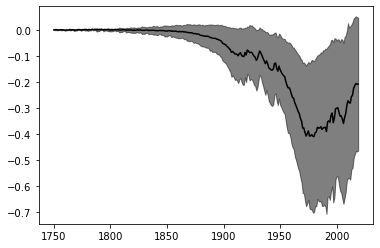

In [15]:
pl.fill_between(np.arange(1750, 2020), np.percentile(ERFari, 5, axis=1), np.percentile(ERFari, 95, axis=1), color='k', alpha=0.5)
pl.plot(np.arange(1750,2020), np.percentile(ERFari, 50, axis=1), color='k')

In [16]:
df = pd.read_csv('/nfs/see-fs-02_users/mencsm/my_papers/AR6_aerosols/data/obs/Bellouin_MERRA2.csv', index_col=0)
merra_ari_median = df['RFari'].values * -0.3/df['RFari'].values[25:35].mean()
merra_aci_median = df['RFaci'].values * -1.0/df['RFaci'].values[25:35].mean()

df = pd.read_csv('/nfs/see-fs-02_users/mencsm/my_papers/AR6_aerosols/data/obs/Bellouin_CAMS.csv', index_col=0)
cams_ari_median = df['RFari'].values * -0.3/df['RFari'].values[2:12].mean()
cams_aci_median = df['RFaci'].values * -1.0/df['RFaci'].values[2:12].mean()

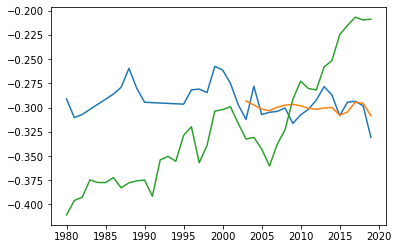

In [17]:
pl.plot(np.arange(1980,2020), merra_ari_median)
pl.plot(np.arange(2003,2020), cams_ari_median)
pl.plot(np.arange(1980,2020), ERFari_median[230:])

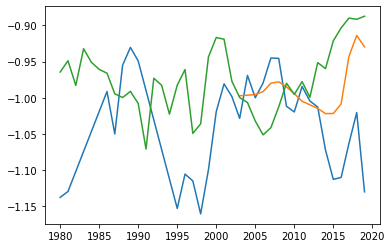

In [18]:
pl.plot(np.arange(1980,2020), np.mean(merra_aci, axis=1))
pl.plot(np.arange(2003,2020), np.mean(cams_aci, axis=1))
pl.plot(np.arange(1980,2020), ERFaci_median[230:])

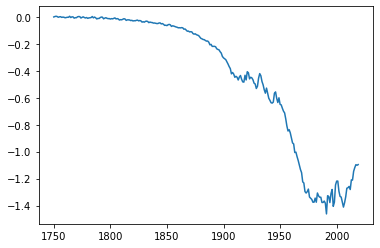

In [19]:
#forcing['aerosol-radiation_interactions'] = np.zeros((270, samples))
#forcing['aerosol-cloud_interactions'] = np.zeros((270, samples))
forcing['aerosol-radiation_interactions'] = ERFari_median
#forcing['aerosol-radiation_interactions'][230:253] = np.linspace(1,0,23) * ERFari_median[230:253] + (np.linspace(0,1,23) * merra_ari_median[:23])
#forcing['aerosol-radiation_interactions'][253:] = np.mean((merra_ari_median[23:], cams_ari_median), axis=0)
forcing['aerosol-cloud_interactions'] = ERFaci_median
#forcing['aerosol-cloud_interactions'][230:253] = np.linspace(1,0,23) * ERFaci_median[230:253] + (np.linspace(0,1,23) * merra_aci_median[:23])
#forcing['aerosol-cloud_interactions'][253:] = np.mean((merra_aci_median[23:], cams_aci_median), axis=0)

forcing['aerosol'] = forcing['aerosol-radiation_interactions'] + forcing['aerosol-cloud_interactions']
pl.plot(forcing['aerosol'])

In [20]:
forcing['aerosol'][-15:]

year
2005   -1.374678
2006   -1.411520
2007   -1.379059
2008   -1.335502
2009   -1.271313
2010   -1.268022
2011   -1.258070
2012   -1.281086
2013   -1.209473
2014   -1.211277
2015   -1.146231
2016   -1.118605
2017   -1.096682
2018   -1.101152
2019   -1.096146
dtype: float64

## Contrail forcing

Based on Lee et al 2018 forcing of 0.0574 and scales with aviation NOx emissions. 

In [21]:
df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/NOx_global_CEDS_emissions_by_sector_2020_09_11.csv')
avi_nox_hist = df[df.sector.str.endswith("aviation")].loc[:,'X1750':'X2019']
avi_nox_hist

,X1750,X1751,X1752,X1753,X1754,X1755,X1756,X1757,X1758,X1759,...,X2010,X2011,X2012,X2013,X2014,X2015,X2016,X2017,X2018,X2019
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1997.776649,2069.475814,2087.063345,2124.952721,2194.826724,2314.759142,2416.613979,2554.457818,2573.144376,2570.985771
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,989.973913,1011.687027,1038.941913,1063.819545,1102.943097,1162.928103,1226.453673,1313.710535,1341.063733,1352.423333


In [22]:
avi_nox_1750_2019 = (avi_nox_hist.sum(axis=0)/1000.).values
contrail_forcing_2018 = 0.0574
forcing['contrails'] = (avi_nox_1750_2019/avi_nox_1750_2019[268] * contrail_forcing_2018)#[:,None] * scale_df['contrails'][None,:]
#pl.plot(np.arange(1750,2020), np.percentile(forcing['contrails'], 95, axis=1))
#pl.plot(np.arange(1750,2020), np.median(forcing['contrails'], axis=1))
#pl.plot(np.arange(1750,2020), np.percentile(forcing['contrails'], 5, axis=1))
forcing['contrails'][-1]

0.05753492821428848

## Land use forcing

Use Ghimire et al. 2014 up to 2005, then FaIR cumulative emissions to 2019, scale to 0.15 W/m2 for 1750 to 2019, and then add --0.05 for irrigation

**TODO: get actual figures from Ghimire, rather than this curve fit**

In [23]:
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
ghimire = pd.read_csv('../data_input/ghimire_curve_fit.csv')
landuse_co2 = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|CO2|MAGICC AFOLU'),'1750':'2020'].interpolate(axis=1, pad=True).values

In [24]:
lusf2019 = -0.15/np.cumsum(landuse_co2)  # include irrigation of -0.05 in Sherwood et al
landuse_erf = np.cumsum(landuse_co2)*lusf2019
f = interp1d(ghimire['year'], ghimire['flux'], kind='linear', fill_value='extrapolate', bounds_error=False)
lusf2019 = -0.20/(f(2019)-f(1750))
forcing['land_use'] = lusf2019*(f(np.arange(1750,2020))-f(1750))#[:,None] * scale_df['land_use'][None,:]
#pl.plot(np.arange(1750,2020), np.percentile(forcing['land_use'], 95, axis=1))
#pl.plot(np.arange(1750,2020), np.median(forcing['land_use'], axis=1))
#pl.plot(np.arange(1750,2020), np.percentile(forcing['land_use'], 5, axis=1))

## BC on snow

Linear with emissions, 2019 = 0.08

In [25]:
df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/BC_global_CEDS_emissions_by_sector_2020_09_11.csv')
bc_hist = df.loc[:,'X1750':'X2019'].sum(axis=0).values/1000.
bc_hist

#bc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions['Variable']=='Emissions|BC'),'1750':'2020'].interpolate(axis=1, pad=True).values.squeeze()

forcing['bc_on_snow'] = (0.08*(bc_hist[:270]-bc_hist[0])/(bc_hist[269]-bc_hist[0]))#[:,None] * scale_df['bc_on_snow'][None,:]
#pl.plot(np.arange(1750,2020), np.percentile(forcing['bc_on_snow'], 95, axis=1));
#pl.plot(np.arange(1750,2020), np.median(forcing['bc_on_snow'], axis=1));
#pl.plot(np.arange(1750,2020), np.percentile(forcing['bc_on_snow'], 5, axis=1));

## Greenhouse gas concentrations

**TODO** what are we doing about +5% in non-CO2 gases?

In [26]:
ghg_obs = pd.read_excel('../data_input/LLGHG_history_AR6_v8a.xlsx', skiprows=22, sheet_name="MR_output", index_col=0)
for addyear in range(1751,1850):
    ghg_obs.loc[addyear, 'YYYY'] = np.nan
ghg_obs = ghg_obs.sort_index()
ghg_obs = ghg_obs.interpolate()
ghg_obs

,CO2,CH4,N2O,HFC-134a,HFC-23,HFC-32,HFC-125,HFC-143a,HFC-152a,HFC-227ea,...,C7F16,C8F18,CFC-112,CFC-112a,CFC-113a,CFC-114a,HCFC-133a,HCFC-31,HCFC-124,YYYY
YYYY,,,,,,,,,,,,,,,,,,,,,
1750,278.70,724.1000,270.0000,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.000,0.00,NaN
1751,278.78,724.9350,270.0250,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.000,0.00,NaN
1752,278.86,725.7700,270.0500,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.000,0.00,NaN
1753,278.94,726.6050,270.0750,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.000,0.00,NaN
1754,279.02,727.4400,270.1000,0.0000,0.000,0.000218,0.0000,0.0000,0.0000,0.000004,...,0.00,0.0,0.000,0.000,0.00,0.00,0.00000,0.000,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,399.41,1833.8905,328.3025,83.4145,28.042,9.985158,18.0910,17.5655,6.5970,1.096239,...,0.11,0.0,0.424,0.066,0.62,1.05,0.39897,0.083,1.02,NaN
2016,402.86,1842.0015,329.1240,89.4825,28.950,11.972602,20.4815,19.1555,6.6600,1.205802,...,0.11,0.0,0.416,0.067,0.66,1.04,0.42501,0.083,1.02,NaN
2017,405.00,1849.2615,330.0400,95.7485,29.975,14.153317,23.2450,20.8340,6.8175,1.327504,...,0.11,0.0,0.416,0.067,0.66,1.04,0.43989,0.083,1.02,NaN


In [27]:
gases = ghg_obs.columns.to_list()
gases.remove('YYYY')

In [28]:
# meinshausen/nicholls rcmip set
#conc={}
#gases=['CO2','CH4','N2O',
#     'HFC125','HFC134a','HFC143a','HFC152a','HFC227ea','HFC23','HFC236fa','HFC245fa','HFC32','HFC365mfc','HFC4310mee',
#     'NF3','C2F6','C3F8','C4F10','C5F12','C6F14','C7F16','C8F18','CF4','cC4F8','SF6','SO2F2','CCl4','CFC11','CFC113',
#     'CFC114','CFC115','CFC12','CH2Cl2','CH3Br','CH3CCl3','CH3Cl','CHCl3','HCFC141b','HCFC142b','HCFC22','Halon1211',
#     'Halon1301','Halon2402']

#for gas in gases:
#    conc[gas] = concentrations[(concentrations.Region=="World")&(concentrations.Scenario==scenario)&(concentrations.Variable.str.endswith(gas))].loc[:,'1750':'2019'].squeeze()
#conc[scenario]['CO2'] = df[(df.Region=="World")&(df.Scenario==scenario)&(df.Variable.str.endswith('CO2'))].loc[:,'1750':'2019']
#conc[scenario]['CH4'] = df[(df.Region=="World")&(df.Scenario==scenario)&(df.Variable.str.endswith('CH4'))].loc[:,'1750':'2019']
#conc[scenario]['N2O'] = df[(df.Region=="World")&(df.Scenario==scenario)&(df.Variable.str.endswith('N2O'))].loc[:,'1750':'2019']

In [29]:
forcing['co2'] = np.zeros((270,samples))
forcing['ch4'] = np.zeros((270,samples))
forcing['n2o'] = np.zeros((270,samples))
co2base = np.zeros(270)
ch4base = np.zeros(270)
n2obase = np.zeros(270)
c = np.array([ghg_obs['CO2'].values, ghg_obs['CH4'].values, ghg_obs['N2O'].values])
for i, year in enumerate(range(1750,2020)):
    co2base[i], ch4base[i], n2obase[i] = meinshausen(c[:,i], [ghg_obs.loc[1750,'CO2'], ghg_obs.loc[1750,'CH4'], ghg_obs.loc[1750,'N2O']], scale_F2x=False)


# include rapid adjustments for CO2 and CH4 (FOD numbers):
forcing['co2'] = 1.05 * co2base#[:,None] * scale_df['co2'][None,:]
forcing['ch4'] = 0.86 * ch4base#[:,None] * scale_df['ch4'][None,:]
forcing['n2o'] = n2obase#[:,None] * scale_df['n2o'][None,:]

In [30]:
# These radiative efficiencies are from Oivind H
radeff = {
    'HFC-125':      0.23378,
    'HFC-134a':     0.16714,
    'HFC-143a':     0.168,
    'HFC-152a':     0.10174,
    'HFC-227ea':    0.27325,
    'HFC-23':       0.19111,
    'HFC-236fa':    0.25069,
    'HFC-245fa':    0.24498,
    'HFC-32':       0.11144,
    'HFC-365mfc':   0.22813,
    'HFC-43-10mee': 0.35731,
    'NF3':          0.20448,
    'C2F6':         0.26105,
    'C3F8':         0.26999,
    'n-C4F10':      0.36874,
    'n-C5F12':      0.4076,
    'n-C6F14':      0.44888,
    'i-C6F14':      0.44888,
    'C7F16':        0.50312,
    'C8F18':        0.55787,
    'CF4':          0.09859,
    'c-C4F8':       0.31392,
    'SF6':          0.56657,
    'SO2F2':        0.21074,
    'CCl4':         0.16616,
    'CFC-11':       0.25941,
    'CFC-112':      0.28192,
    'CFC-112a':     0.24564,
    'CFC-113':      0.30142,
    'CFC-113a':     0.24094, 
    'CFC-114':      0.31433,
    'CFC-114a':     0.29747,
    'CFC-115':      0.24625,
    'CFC-12':       0.31998,
    'CFC-13':       0.27752,
    'CH2Cl2':       0.02882,
    'CH3Br':        0.00432,
    'CH3CCl3':      0.06454,
    'CH3Cl':        0.00466,
    'CHCl3':        0.07357,
    'HCFC-124':     0.20721,
    'HCFC-133a':    0.14995,
    'HCFC-141b':    0.16065,
    'HCFC-142b':    0.19329,
    'HCFC-22':      0.21385,
    'HCFC-31':      0.068,
    'Halon-1211':   0.30014,
    'Halon-1301':   0.29943,
    'Halon-2402':   0.31169,
}

otherghgbase = np.zeros(270)
for gas in gases[3:]:
    forcing[gas] = (ghg_obs.loc[:,gas] - ghg_obs.loc[1750,gas]).values * radeff[gas] * 0.001
    otherghgbase = otherghgbase + forcing[gas]
forcing['other_wmghg'] = otherghgbase

In [31]:
# pl.fill_between(np.arange(1750,2020),np.percentile(forcing['co2'], 5, axis=1), np.percentile(forcing['co2'], 95, axis=1), color='b', alpha=0.3)
# pl.plot(np.arange(1750,2020),np.median(forcing['co2'], axis=1), color='b')
# pl.fill_between(np.arange(1750,2020),np.percentile(forcing['ch4'], 5, axis=1), np.percentile(forcing['ch4'], 95, axis=1), color='r', alpha=0.3)
# pl.plot(np.arange(1750,2020),np.median(forcing['ch4'], axis=1), color='r')
# pl.fill_between(np.arange(1750,2020),np.percentile(forcing['n2o'], 5, axis=1), np.percentile(forcing['n2o'], 95, axis=1), color='g', alpha=0.3)
# pl.plot(np.arange(1750,2020),np.median(forcing['n2o'], axis=1), color='g')
# pl.fill_between(np.arange(1750,2020),np.percentile(forcing['other_wmghg'], 5, axis=1), np.percentile(forcing['other_wmghg'], 95, axis=1), color='y', alpha=0.3)
# pl.plot(np.arange(1750,2020),np.median(forcing['other_wmghg'], axis=1), color='y')

## Tropospheric ozone

Follow Skeie et al., 2020 exclusively for the historical

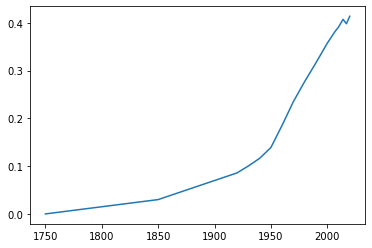

In [32]:
good_models = ['BCC-ESM1', 'CESM2(WACCM6)', 'GFDL-ESM4', 'GISS-E2-1-H', 'MRI-ESM2-0', 'OsloCTM3']
skeie_trop = pd.read_csv('../data_input/skeie_ozone_trop.csv', index_col=0)
skeie_trop = skeie_trop.loc[good_models]
skeie_trop.insert(0, 1850, 0)
skeie_trop.columns = pd.to_numeric(skeie_trop.columns)
skeie_trop.interpolate(axis=1, method='values', limit_area='inside', inplace=True)
skeie_trop.insert(0, 1750, -0.03)
skeie_trop_post2010 = skeie_trop.loc['OsloCTM3',[2014,2017,2020]]-skeie_trop.loc['OsloCTM3', 2010]
skeie_trop.loc[:,[2014,2017,2020]] = skeie_trop.loc[:,2010:2010].values + skeie_trop_post2010.values[None,:]
skeie_trop = skeie_trop + 0.03
pl.plot(skeie_trop.mean())

In [33]:
f = interp1d(skeie_trop.columns, skeie_trop.mean(), bounds_error=False, fill_value='extrapolate')
years = np.arange(1750,2020)
forcing['o3_trop'] = f(years)#[:,None] * scale_df['o3_tropospheric'][None,:]

## Stratospheric ozone

As above

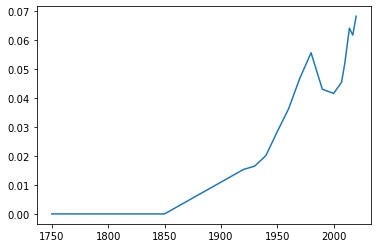

In [34]:
good_models = ['BCC-ESM1', 'CESM2(WACCM6)', 'GFDL-ESM4', 'GISS-E2-1-H', 'MRI-ESM2-0', 'OsloCTM3']
skeie_strat = pd.read_csv('../data_input/skeie_ozone_strat.csv', index_col=0)
skeie_strat = skeie_strat.loc[good_models]
skeie_strat.insert(0, 1850, 0)
skeie_strat.columns = pd.to_numeric(skeie_strat.columns)
skeie_strat.interpolate(axis=1, method='values', limit_area='inside', inplace=True)
skeie_strat.insert(0, 1750, 0)
skeie_strat_post2010 = skeie_strat.loc['OsloCTM3',[2014,2017,2020]]-skeie_strat.loc['OsloCTM3', 2010]
skeie_strat.loc[:,[2014,2017,2020]] = skeie_strat.loc[:,2010:2010].values + skeie_strat_post2010.values[None,:]
pl.plot(skeie_strat.mean())

In [35]:
f = interp1d(skeie_strat.columns, skeie_strat.mean(), bounds_error=False, fill_value='extrapolate')
years = np.arange(1750,2020)
forcing['o3_strat'] = f(years)#[:,None] * scale_df['o3_stratospheric'][None,:]

## Stratospheric water vapour

In [36]:
forcing['ch4'].shape

(270,)

In [37]:
sfh2ostrat = 0.05 / forcing['ch4'][269]
#forcing['h2o_strat'] = (forcing['ch4'] * sfh2ostrat[None,:]) * scale_df['h2o_stratospheric'][None,:]
forcing['h2o_strat'] = (forcing['ch4'] * sfh2ostrat)
forcing['h2o_strat'].shape

(270,)

Text(0.5, 1.0, 'solar')

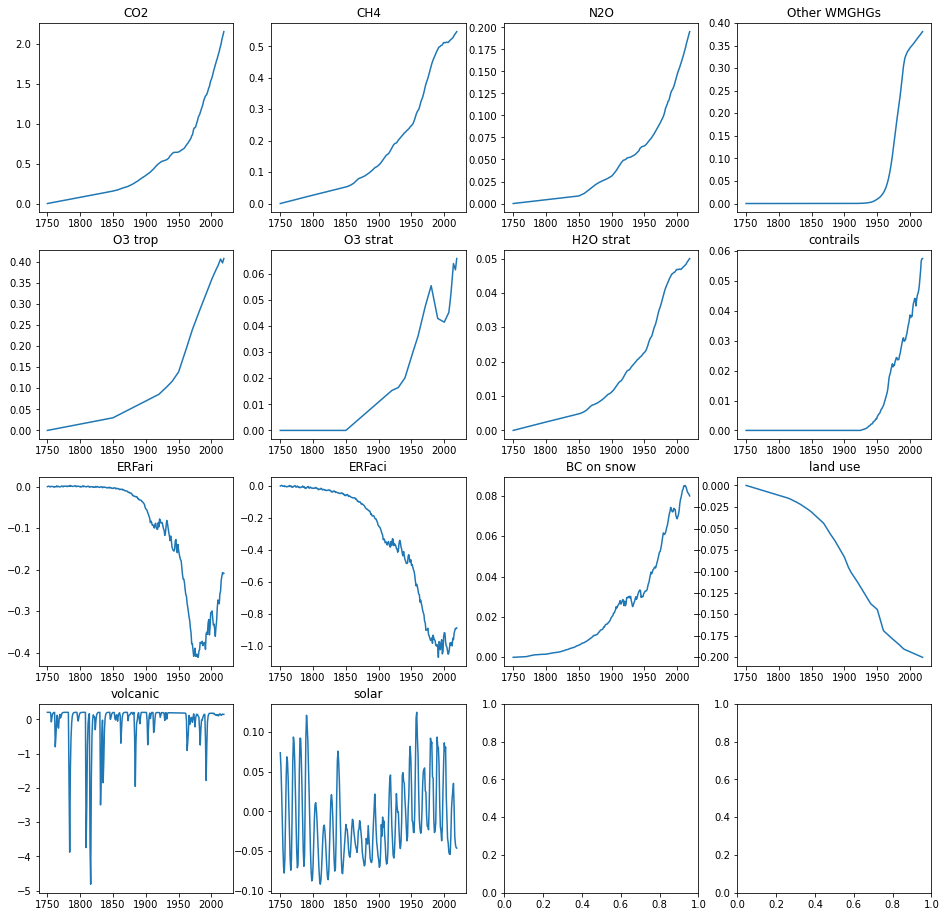

In [38]:
# solar forcing will use the averages of the solar cycles from 1745 to 1765 as the baseline: this is a different treatment to CMIP6
fig, ax = pl.subplots(4,4, figsize=(16,16),squeeze=True)
ax[0,0].plot(np.arange(1750,2020),forcing['co2'])
ax[0,0].set_title('CO2')
ax[0,1].plot(np.arange(1750,2020),forcing['ch4'])
ax[0,1].set_title('CH4')
ax[0,2].plot(np.arange(1750,2020),forcing['n2o'])
ax[0,2].set_title('N2O')
ax[0,3].plot(np.arange(1750,2020),forcing['other_wmghg'])
ax[0,3].set_title('Other WMGHGs')
ax[1,0].plot(np.arange(1750,2020),forcing['o3_trop'])
ax[1,0].set_title('O3 trop')
ax[1,1].plot(np.arange(1750,2020),forcing['o3_strat'])
ax[1,1].set_title('O3 strat')
ax[1,2].plot(np.arange(1750,2020),forcing['h2o_strat'])
ax[1,2].set_title('H2O strat')
ax[1,3].plot(np.arange(1750,2020),forcing['contrails'])
ax[1,3].set_title('contrails')
ax[2,0].plot(np.arange(1750,2020),forcing['aerosol-radiation_interactions'])
ax[2,0].set_title('ERFari')
ax[2,1].plot(np.arange(1750,2020),forcing['aerosol-cloud_interactions'])
ax[2,1].set_title('ERFaci')
ax[2,2].plot(np.arange(1750,2020),forcing['bc_on_snow'])
ax[2,2].set_title('BC on snow')
ax[2,3].plot(np.arange(1750,2020),forcing['land_use'])
ax[2,3].set_title('land use')
ax[3,0].plot(np.arange(1750,2020),forcing['volcanic'])
ax[3,0].set_title('volcanic')
ax[3,1].plot(np.arange(1750,2020),forcing['solar'])
ax[3,1].set_title('solar')

In [39]:
forcing['total_anthropogenic']=forcing['co2']+forcing['ch4']+forcing['n2o']+\
    forcing['other_wmghg']+\
    forcing['o3_trop']+forcing['o3_strat']+forcing['h2o_strat']+forcing['contrails']+\
    forcing['aerosol-radiation_interactions']+forcing['aerosol-cloud_interactions']+forcing['bc_on_snow']+forcing['land_use']
forcing['total_natural']=forcing['volcanic']+forcing['solar']
forcing['total']=forcing['total_anthropogenic']+forcing['total_natural']

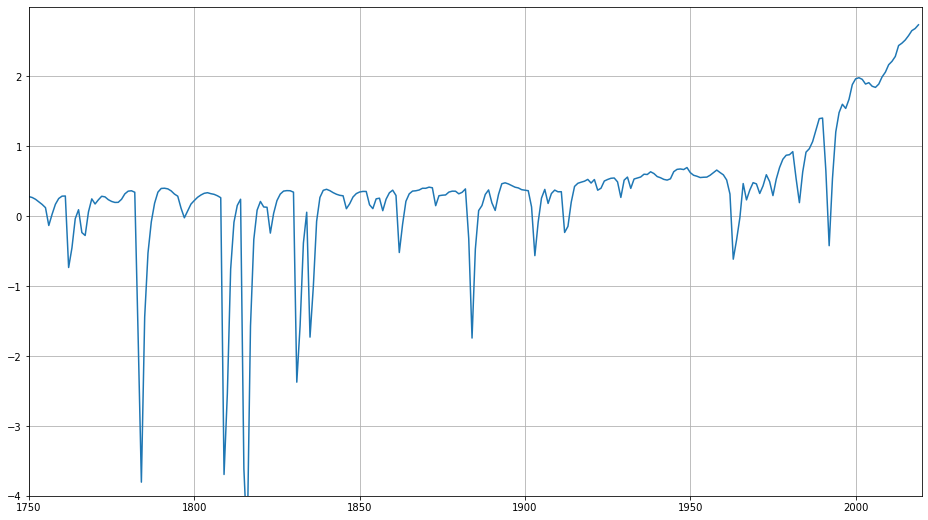

In [40]:
pl.figure(figsize=(16,9))
pl.plot(np.arange(1750,2020), forcing['total'])
pl.yticks(np.arange(-4,3))
pl.xticks(np.arange(1750,2020,50))
pl.ylim(-4,3)
pl.xlim(1750,2020)
pl.grid()

In [41]:
#np.percentile(forcing['total'][-1,:],(5,50,95))
#np.percentile(forcing['total_anthropogenic'][-1,:],(5,50,95))

In [42]:
df = pd.DataFrame(data=forcing, index=np.arange(1750,2020))
df.index.name = 'year'
df=df[['co2','ch4','n2o','other_wmghg','o3_trop','o3_strat','h2o_strat','contrails','aerosol-radiation_interactions','aerosol-cloud_interactions','bc_on_snow','land_use',
  'volcanic','solar','total_anthropogenic','total_natural','total']]
df.to_csv('../data_output/AR6_ERF_1750-2019.csv')
df

,co2,ch4,n2o,other_wmghg,o3_trop,o3_strat,h2o_strat,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,total_anthropogenic,total_natural,total
year,,,,,,,,,,,,,,,,,
1750,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.206975,0.073621,0.000000,0.280596,0.280596
1751,0.001571,0.000543,0.000086,7.958010e-10,0.000300,0.000000,0.000050,0.000000,0.000592,0.002589,0.000017,-0.000229,0.206987,0.055275,0.005521,0.262262,0.267783
1752,0.003142,0.001086,0.000173,1.591602e-09,0.000600,0.000000,0.000099,0.000000,0.001203,0.004029,0.000035,-0.000458,0.206991,0.025197,0.009910,0.232188,0.242098
1753,0.004712,0.001629,0.000259,2.387403e-09,0.000900,0.000000,0.000149,0.000000,0.000562,0.002377,0.000052,-0.000687,0.206993,-0.010981,0.009953,0.196012,0.205965
1754,0.006282,0.002171,0.000346,3.183204e-09,0.001200,0.000000,0.000198,0.000000,-0.000771,-0.001703,0.000070,-0.000916,0.206993,-0.045395,0.006876,0.161598,0.168474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,2.001776,0.535137,0.184062,3.732417e-01,0.404167,0.063233,0.048900,0.050999,-0.224922,-0.921309,0.082637,-0.198663,0.116647,0.005228,2.399257,0.121875,2.521132
2016,2.050532,0.538162,0.186453,3.751911e-01,0.401100,0.062433,0.049177,0.053424,-0.215176,-0.903429,0.081655,-0.198998,0.134186,-0.031556,2.480525,0.102630,2.583155
2017,2.080581,0.540854,0.189147,3.774247e-01,0.398033,0.061633,0.049423,0.056725,-0.206797,-0.889885,0.081292,-0.199332,0.157610,-0.041435,2.539099,0.116175,2.655274


In [43]:
df.loc[2000:2020]

,co2,ch4,n2o,other_wmghg,o3_trop,o3_strat,h2o_strat,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,total_anthropogenic,total_natural,total
year,,,,,,,,,,,,,,,,,
2000,1.552699,0.512465,0.146780,0.345242,0.357217,0.041550,0.046829,0.038652,-0.302113,-0.916689,0.068669,-0.193651,0.182106,0.086039,1.697648,0.268146,1.965794
2001,1.576555,0.511833,0.149065,0.347165,0.360762,0.042090,0.046771,0.037784,-0.299241,-0.919048,0.069730,-0.193985,0.176846,0.075478,1.729482,0.252324,1.981806
2002,1.606972,0.512160,0.151034,0.348908,0.364307,0.042631,0.046801,0.038350,-0.316375,-0.976991,0.070833,-0.194319,0.183630,0.080766,1.694310,0.264396,1.958706
2003,1.645201,0.513707,0.153176,0.350486,0.367852,0.043171,0.046942,0.038179,-0.332462,-0.999621,0.072814,-0.194654,0.167275,0.019394,1.704793,0.186669,1.891461
2004,1.672599,0.513494,0.155169,0.352206,0.371398,0.043712,0.046923,0.040689,-0.330857,-1.006455,0.076183,-0.194988,0.178190,-0.007392,1.740072,0.170797,1.910869
2005,1.702703,0.512675,0.157336,0.354011,0.374943,0.044252,0.046848,0.042421,-0.342683,-1.031995,0.078143,-0.195322,0.150464,-0.033851,1.743333,0.116613,1.859946
2006,1.734291,0.512722,0.159892,0.355778,0.378488,0.044793,0.046852,0.043095,-0.360329,-1.051192,0.079359,-0.195656,0.135359,-0.039857,1.748094,0.095501,1.843595
2007,1.759977,0.515327,0.162141,0.357848,0.382033,0.045333,0.047090,0.044202,-0.337821,-1.041237,0.081129,-0.195990,0.121751,-0.051371,1.820033,0.070380,1.890413
2008,1.790986,0.517825,0.164860,0.360018,0.385033,0.047567,0.047319,0.044006,-0.322882,-1.012620,0.082698,-0.196324,0.138290,-0.053851,1.908486,0.084439,1.992925


In [44]:
df = pd.DataFrame(data=forcing, index=np.arange(1750,2020))
df.index.name='year'
df=df[gases[3:]]
df.to_csv('../data_output/AR6_ERF_minorGHGs_1750-2019.csv')
df

,HFC-134a,HFC-23,HFC-32,HFC-125,HFC-143a,HFC-152a,HFC-227ea,HFC-236fa,HFC-245fa,HFC-365mfc,...,i-C6F14,C7F16,C8F18,CFC-112,CFC-112a,CFC-113a,CFC-114a,HCFC-133a,HCFC-31,HCFC-124
year,,,,,,,,,,,,,,,,,,,,,
1750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1751,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1752,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1753,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1754,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,0.013942,0.005359,0.001113,0.004229,0.002951,0.000671,0.000300,0.000036,0.000547,0.000195,...,0.000028,0.000055,0.0,0.000120,0.000016,0.000149,0.000312,0.000060,0.000006,0.000211
2016,0.014956,0.005533,0.001334,0.004788,0.003218,0.000678,0.000329,0.000038,0.000594,0.000212,...,0.000028,0.000055,0.0,0.000117,0.000016,0.000159,0.000309,0.000064,0.000006,0.000211
2017,0.016003,0.005729,0.001577,0.005434,0.003500,0.000694,0.000363,0.000042,0.000646,0.000226,...,0.000028,0.000055,0.0,0.000117,0.000016,0.000159,0.000309,0.000066,0.000006,0.000211


## Uncertainties

In [45]:
forcing_ensemble = {}
df = pd.DataFrame(data=forcing, index=np.arange(1750,2020))
df.index.name = 'year'
df=df[['co2','ch4','n2o','other_wmghg','o3_trop','o3_strat','h2o_strat','contrails','aerosol-radiation_interactions','aerosol-cloud_interactions','bc_on_snow','land_use',
  'volcanic','solar','total_anthropogenic','total_natural','total']]

forcing_ensemble['co2'] = df['co2'][:,None] * scale_df['co2'][None,:]
forcing_ensemble['ch4'] = df['ch4'][:,None] * scale_df['ch4'][None,:]
forcing_ensemble['n2o'] = df['n2o'][:,None] * scale_df['n2o'][None,:]
forcing_ensemble['other_wmghg'] = df['other_wmghg'][:,None] * scale_df['other_wmghg'][None,:]
forcing_ensemble['o3_trop'] = df['o3_trop'][:,None] * scale_df['o3_tropospheric'][None,:]
forcing_ensemble['o3_strat'] = df['o3_strat'][:,None] * scale_df['o3_tropospheric'][None,:]
forcing_ensemble['h2o_strat'] = df['h2o_strat'][:,None] * scale_df['h2o_stratospheric'][None,:]
forcing_ensemble['contrails'] = df['contrails'][:,None] * scale_df['contrails'][None,:]
forcing_ensemble['aerosol-radiation_interactions'] = ERFari
forcing_ensemble['aerosol-cloud_interactions'] = ERFaci
forcing_ensemble['bc_on_snow'] = df['bc_on_snow'][:,None] * scale_df['bc_on_snow'][None,:]
forcing_ensemble['land_use'] = df['land_use'][:,None] * scale_df['land_use'][None,:]
forcing_ensemble['volcanic'] = df['volcanic'][:,None] * scale_df['volcanic'][None,:]
forcing_ensemble['solar'] = df['solar'][:,None] * scale_df['solar'][None,:]

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':
/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Suppo

Text(0.5, 1.0, 'solar')

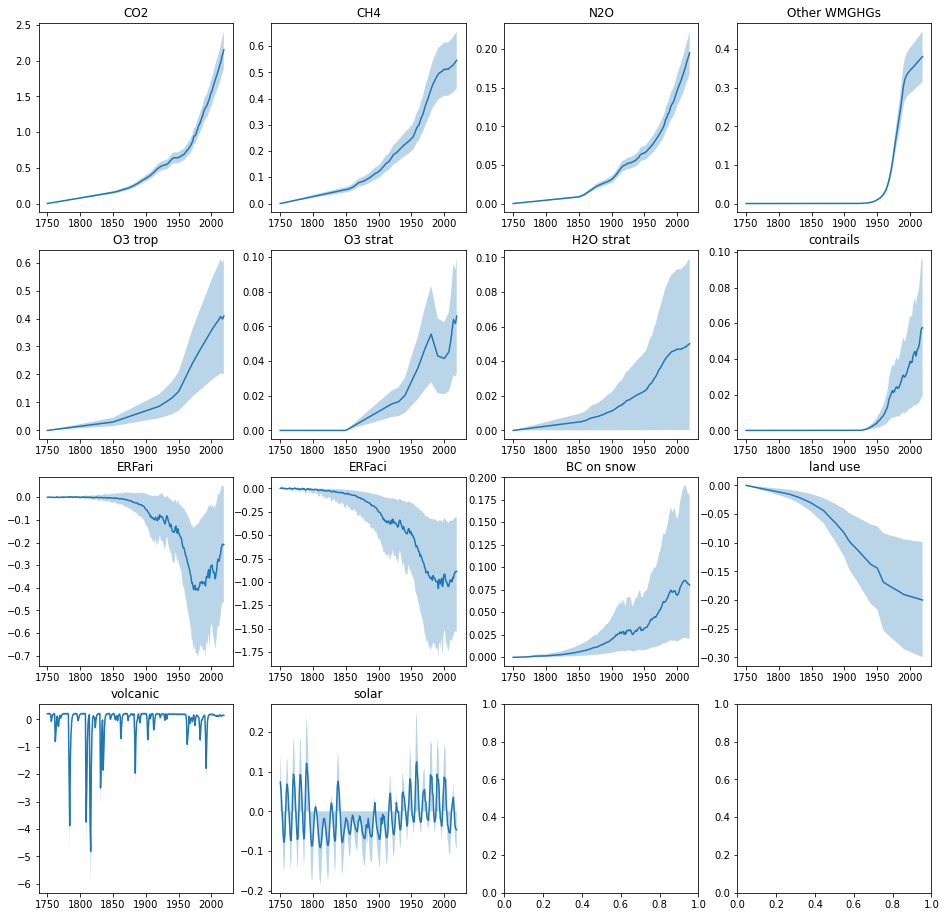

In [46]:
# solar forcing_ensemble will use the averages of the solar cycles from 1745 to 1765 as the baseline: this is a different treatment to CMIP6
fig, ax = pl.subplots(4,4, figsize=(16,16),squeeze=True)
ax[0,0].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['co2'],5,axis=1),np.percentile(forcing_ensemble['co2'],95,axis=1), alpha=0.3)
ax[0,0].plot(np.arange(1750,2020),np.median(forcing_ensemble['co2'],axis=1))
ax[0,0].set_title('CO2')
ax[0,1].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['ch4'],5,axis=1),np.percentile(forcing_ensemble['ch4'],95,axis=1), alpha=0.3)
ax[0,1].plot(np.arange(1750,2020),np.median(forcing_ensemble['ch4'],axis=1))
ax[0,1].set_title('CH4')
ax[0,2].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['n2o'],5,axis=1),np.percentile(forcing_ensemble['n2o'],95,axis=1), alpha=0.3)
ax[0,2].plot(np.arange(1750,2020),np.median(forcing_ensemble['n2o'],axis=1))
ax[0,2].set_title('N2O')
ax[0,3].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['other_wmghg'],5,axis=1),np.percentile(forcing_ensemble['other_wmghg'],95,axis=1), alpha=0.3)
ax[0,3].plot(np.arange(1750,2020),np.median(forcing_ensemble['other_wmghg'],axis=1))
ax[0,3].set_title('Other WMGHGs')
ax[1,0].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['o3_trop'],5,axis=1),np.percentile(forcing_ensemble['o3_trop'],95,axis=1), alpha=0.3)
ax[1,0].plot(np.arange(1750,2020),np.median(forcing_ensemble['o3_trop'],axis=1))
ax[1,0].set_title('O3 trop')
ax[1,1].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['o3_strat'],5,axis=1),np.percentile(forcing_ensemble['o3_strat'],95,axis=1), alpha=0.3)
ax[1,1].plot(np.arange(1750,2020),np.median(forcing_ensemble['o3_strat'],axis=1))
ax[1,1].set_title('O3 strat')
ax[1,2].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['h2o_strat'],5,axis=1),np.percentile(forcing_ensemble['h2o_strat'],95,axis=1), alpha=0.3)
ax[1,2].plot(np.arange(1750,2020),np.median(forcing_ensemble['h2o_strat'],axis=1))
ax[1,2].set_title('H2O strat')
ax[1,3].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['contrails'],5,axis=1),np.percentile(forcing_ensemble['contrails'],95,axis=1), alpha=0.3)
ax[1,3].plot(np.arange(1750,2020),np.median(forcing_ensemble['contrails'],axis=1))
ax[1,3].set_title('contrails')
ax[2,0].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['aerosol-radiation_interactions'],5,axis=1),np.percentile(forcing_ensemble['aerosol-radiation_interactions'],95,axis=1), alpha=0.3)
ax[2,0].plot(np.arange(1750,2020),forcing['aerosol-radiation_interactions'])
ax[2,0].set_title('ERFari')
ax[2,1].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['aerosol-cloud_interactions'],5,axis=1),np.percentile(forcing_ensemble['aerosol-cloud_interactions'],95,axis=1), alpha=0.3)
ax[2,1].plot(np.arange(1750,2020),forcing['aerosol-cloud_interactions'])
ax[2,1].set_title('ERFaci')
ax[2,2].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['bc_on_snow'],5,axis=1),np.percentile(forcing_ensemble['bc_on_snow'],95,axis=1), alpha=0.3)
ax[2,2].plot(np.arange(1750,2020),np.median(forcing_ensemble['bc_on_snow'],axis=1))
ax[2,2].set_title('BC on snow')
ax[2,3].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['land_use'],5,axis=1),np.percentile(forcing_ensemble['land_use'],95,axis=1), alpha=0.3)
ax[2,3].plot(np.arange(1750,2020),np.median(forcing_ensemble['land_use'],axis=1))
ax[2,3].set_title('land use')
ax[3,0].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['volcanic'],5,axis=1),np.percentile(forcing_ensemble['volcanic'],95,axis=1), alpha=0.3)
ax[3,0].plot(np.arange(1750,2020),np.median(forcing_ensemble['volcanic'],axis=1))
ax[3,0].set_title('volcanic')
ax[3,1].fill_between(np.arange(1750,2020),np.percentile(forcing_ensemble['solar'],5,axis=1),np.percentile(forcing_ensemble['solar'],95,axis=1), alpha=0.3)
ax[3,1].plot(np.arange(1750,2020),np.median(forcing_ensemble['solar'],axis=1))
ax[3,1].set_title('solar')

In [47]:
print(np.percentile(forcing_ensemble['aerosol-radiation_interactions'],5,axis=1)[255:265].mean())
print(np.percentile(forcing_ensemble['aerosol-radiation_interactions'],95,axis=1)[255:265].mean())
print(np.percentile(forcing_ensemble['aerosol-cloud_interactions'],5,axis=1)[255:265].mean())
print(np.percentile(forcing_ensemble['aerosol-cloud_interactions'],95,axis=1)[255:265].mean())

forcing_ensemble['total']=(forcing_ensemble['co2'] +
                  forcing_ensemble['ch4'] +
                  forcing_ensemble['n2o'] +
                  forcing_ensemble['other_wmghg'] +
                  forcing_ensemble['o3_trop'] +
                  forcing_ensemble['o3_strat'] + 
                  forcing_ensemble['h2o_strat'] + 
                  forcing_ensemble['contrails'] + 
                  forcing_ensemble['bc_on_snow'] +
                  forcing_ensemble['land_use'] +
                  forcing_ensemble['aerosol-radiation_interactions'] + 
                  forcing_ensemble['aerosol-cloud_interactions'] +
                  forcing_ensemble['solar'] +
                  forcing_ensemble['volcanic'])
forcing_ensemble['aerosol'] = (forcing_ensemble['aerosol-radiation_interactions'] + forcing_ensemble['aerosol-cloud_interactions'])
forcing_ensemble['ch2_other_anthro'] = (forcing_ensemble['o3_strat'] + 
                  forcing_ensemble['h2o_strat'] + 
                  forcing_ensemble['contrails'] + 
                  forcing_ensemble['bc_on_snow'] +
                  forcing_ensemble['land_use'])

-0.5947406552570274
-0.00427170782112205
-1.6526401810067892
-0.3483247351278007


In [48]:
df = pd.DataFrame(data=np.array([
    np.percentile(forcing_ensemble['co2'],5,axis=1),
    np.percentile(forcing_ensemble['ch4'],5,axis=1),
    np.percentile(forcing_ensemble['n2o'],5,axis=1),
    np.percentile(forcing_ensemble['other_wmghg'],5,axis=1),
    np.percentile(forcing_ensemble['o3_trop'],5,axis=1),
    np.percentile(forcing_ensemble['o3_strat'],5,axis=1),
    np.percentile(forcing_ensemble['h2o_strat'],5,axis=1),
    np.percentile(forcing_ensemble['contrails'],5,axis=1),
    np.percentile(forcing_ensemble['aerosol-radiation_interactions'],5,axis=1),
    np.percentile(forcing_ensemble['aerosol-cloud_interactions'],5,axis=1),
    np.percentile(forcing_ensemble['bc_on_snow'],5,axis=1),
    np.percentile(forcing_ensemble['land_use'],5,axis=1),
    np.percentile(forcing_ensemble['volcanic'],5,axis=1),    
    np.percentile(forcing_ensemble['solar'],5,axis=1),
    np.percentile(forcing_ensemble['aerosol'],5,axis=1),
    np.percentile(forcing_ensemble['ch2_other_anthro'],5,axis=1),
    np.percentile(forcing_ensemble['total'],5,axis=1)
]).T, index=np.arange(1750,2020))
df.index.name = 'year'
df = df.rename(columns={
    0: 'co2',
    1: 'ch4',
    2: 'n2o',
    3: 'other_wmghg',
    4: 'o3_trop',
    5: 'o3_strat',
    6: 'h2o_strat',
    7: 'contrails',
    8: 'aerosol-radiation_interactions',
    9: 'aerosol-cloud_interactions',
    10:'bc_on_snow',
    11:'land_use',
    12:'volcanic',
    13:'solar',
    14:'aerosol',
    15:'ch2_other_anthro',
    16:'total'
})
df.to_csv('../data_output/AR6_ERF_1750-2019_pc05.csv')
df

,co2,ch4,n2o,other_wmghg,o3_trop,o3_strat,h2o_strat,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,aerosol,ch2_other_anthro,total
year,,,,,,,,,,,,,,,,,
1750,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.154998,-0.000063,0.000000,0.000000,0.190166
1751,0.001381,0.000435,0.000074,6.583681e-10,0.000150,0.000000,2.433551e-07,0.000000,-0.000923,0.000329,0.000004,-0.000343,0.155007,-0.000047,0.000280,-0.000285,0.193593
1752,0.002762,0.000871,0.000149,1.316736e-09,0.000301,0.000000,4.865523e-07,0.000000,-0.001101,0.000468,0.000009,-0.000687,0.155010,-0.000022,0.000712,-0.000571,0.185934
1753,0.004142,0.001305,0.000223,1.975104e-09,0.000451,0.000000,7.295919e-07,0.000000,-0.000997,0.000291,0.000013,-0.001030,0.155011,-0.021987,0.000123,-0.000856,0.154591
1754,0.005522,0.001740,0.000297,2.633472e-09,0.000601,0.000000,9.724743e-07,0.000000,-0.001320,-0.007528,0.000018,-0.001374,0.155011,-0.090898,-0.008304,-0.001142,0.098187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,1.759518,0.428835,0.158099,3.087838e-01,0.202446,0.031673,2.396741e-04,0.016572,-0.493567,-1.546033,0.021003,-0.297879,0.087353,-0.000004,-1.818704,-0.085174,1.755997
2016,1.802374,0.431259,0.160153,3.103965e-01,0.200909,0.031273,2.410290e-04,0.017360,-0.477528,-1.533130,0.020754,-0.298380,0.100488,-0.063187,-1.795474,-0.084919,1.815323
2017,1.828786,0.433417,0.162467,3.122444e-01,0.199373,0.030872,2.422347e-04,0.018432,-0.465609,-1.526917,0.020662,-0.298881,0.118030,-0.082969,-1.775871,-0.083373,1.883722


In [49]:
df = pd.DataFrame(data=np.array([
    np.percentile(forcing_ensemble['co2'],95,axis=1),
    np.percentile(forcing_ensemble['ch4'],95,axis=1),
    np.percentile(forcing_ensemble['n2o'],95,axis=1),
    np.percentile(forcing_ensemble['other_wmghg'],95,axis=1),
    np.percentile(forcing_ensemble['o3_trop'],95,axis=1),
    np.percentile(forcing_ensemble['o3_strat'],95,axis=1),
    np.percentile(forcing_ensemble['h2o_strat'],95,axis=1),
    np.percentile(forcing_ensemble['contrails'],95,axis=1),
    np.percentile(forcing_ensemble['aerosol-radiation_interactions'],95,axis=1),
    np.percentile(forcing_ensemble['aerosol-cloud_interactions'],95,axis=1),
    np.percentile(forcing_ensemble['bc_on_snow'],95,axis=1),
    np.percentile(forcing_ensemble['land_use'],95,axis=1),
    np.percentile(forcing_ensemble['volcanic'],95,axis=1),    
    np.percentile(forcing_ensemble['solar'],95,axis=1),
    np.percentile(forcing_ensemble['aerosol'],95,axis=1),
    np.percentile(forcing_ensemble['ch2_other_anthro'],95,axis=1),
    np.percentile(forcing_ensemble['total'],95,axis=1)
]).T, index=np.arange(1750,2020))
df.index.name = 'year'
#df=df[['co2','ch4','n2o','other_wmghg','o3_trop','other_anthro','aerosols','volcanic','solar','total']]
df = df.rename(columns={
    0: 'co2',
    1: 'ch4',
    2: 'n2o',
    3: 'other_wmghg',
    4: 'o3_trop',
    5: 'o3_strat',
    6: 'h2o_strat',
    7: 'contrails',
    8: 'aerosol-radiation_interactions',
    9: 'aerosol-cloud_interactions',
    10:'bc_on_snow',
    11:'land_use',
    12:'volcanic',
    13:'solar',
    14:'aerosol',
    15:'ch2_other_anthro',
    16:'total'
})
df.to_csv('../data_output/AR6_ERF_1750-2019_pc95.csv')
df

,co2,ch4,n2o,other_wmghg,o3_trop,o3_strat,h2o_strat,contrails,aerosol-radiation_interactions,aerosol-cloud_interactions,bc_on_snow,land_use,volcanic,solar,aerosol,ch2_other_anthro,total
year,,,,,,,,,,,,,,,,,
1750,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.258684,0.147417,0.000000,0.000000,0.370895
1751,0.001760,0.000651,0.000099,9.305376e-10,0.000451,0.000000,0.000099,0.000000,0.002106,0.017593,0.000039,-0.000113,0.258699,0.110681,0.018277,-0.000033,0.346696
1752,0.003519,0.001302,0.000197,1.861075e-09,0.000902,0.000000,0.000197,0.000000,0.003501,0.027756,0.000078,-0.000227,0.258705,0.050454,0.029062,-0.000067,0.305766
1753,0.005278,0.001952,0.000296,2.791613e-09,0.001354,0.000000,0.000296,0.000000,0.002120,0.018000,0.000117,-0.000340,0.258706,0.000009,0.018643,-0.000100,0.262310
1754,0.007037,0.002602,0.000395,3.722150e-09,0.001805,0.000000,0.000394,0.000000,-0.000229,-0.000239,0.000156,-0.000453,0.258707,0.000039,-0.000850,-0.000134,0.236686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,2.242312,0.641222,0.210111,4.364351e-01,0.607885,0.095106,0.097219,0.085321,0.044651,-0.321798,0.185293,-0.098223,0.145789,0.010469,-0.487120,0.205705,3.297150
2016,2.296927,0.644847,0.212840,4.387144e-01,0.603272,0.093903,0.097768,0.089378,0.048207,-0.315960,0.183092,-0.098388,0.167710,0.000027,-0.471163,0.205754,3.350211
2017,2.330587,0.648073,0.215916,4.413262e-01,0.598660,0.092699,0.098257,0.094901,0.052598,-0.309991,0.182276,-0.098553,0.196987,0.000035,-0.459094,0.207680,3.415314


## For Kyle

In [50]:
print('Total 2006-19 minus 1850-1900, 5th', np.percentile(forcing_ensemble['total'][256:270,:].mean(axis=0), 5) - np.percentile(forcing_ensemble['total'][100:151,:].mean(axis=0), 5))
print('Total 2006-19 minus 1850-1900, best', forcing['total'][256:270].mean() - forcing['total'][100:151].mean())
print('Total 2006-19 minus 1850-1900, 50th', np.percentile(forcing_ensemble['total'][256:270,:].mean(axis=0), 50) - np.percentile(forcing_ensemble['total'][100:151,:].mean(axis=0), 50))
print('Total 2006-19 minus 1850-1900, 95th', np.percentile(forcing_ensemble['total'][256:270,:].mean(axis=0), 95) - np.percentile(forcing_ensemble['total'][100:151,:].mean(axis=0), 95))
print()
print('CO2 2006-19 minus 1850-1900, 5th', np.percentile(forcing_ensemble['co2'][256:270,:].mean(axis=0), 5) - np.percentile(forcing_ensemble['co2'][100:151,:].mean(axis=0), 5))
print('CO2 2006-19 minus 1850-1900, best', forcing['co2'][256:270].mean() - forcing['co2'][100:151].mean())
print('CO2 2006-19 minus 1850-1900, 50th', np.percentile(forcing_ensemble['co2'][256:270,:].mean(axis=0), 50) - np.percentile(forcing_ensemble['co2'][100:151,:].mean(axis=0), 50))
print('CO2 2006-19 minus 1850-1900, 95th', np.percentile(forcing_ensemble['co2'][256:270,:].mean(axis=0), 95) - np.percentile(forcing_ensemble['co2'][100:151,:].mean(axis=0), 95))

Total 2006-19 minus 1850-1900, 5th 1.5325316699142408
Total 2006-19 minus 1850-1900, best 2.103302572873599
Total 2006-19 minus 1850-1900, 50th 2.1176983780340137
Total 2006-19 minus 1850-1900, 95th 2.777479827650759

CO2 2006-19 minus 1850-1900, 5th 1.4901769404441327
CO2 2006-19 minus 1850-1900, best 1.6953510015962816
CO2 2006-19 minus 1850-1900, 50th 1.697611556569648
CO2 2006-19 minus 1850-1900, 95th 1.8990669874623982


In [51]:
forcing_ensemble['total'].shape

(270, 25000)

## For Matt

In [52]:
forcing_ensemble['year'] = np.arange(1750, 2020)
save_dict_to_hdf5(forcing_ensemble, '../data_input_large/ERF_ensemble.h5')